Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3829, Hamming Loss: 0.0161

Validation Accuracy: 0.3803, Ha

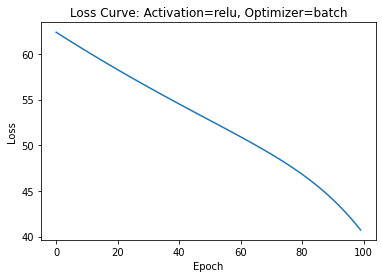

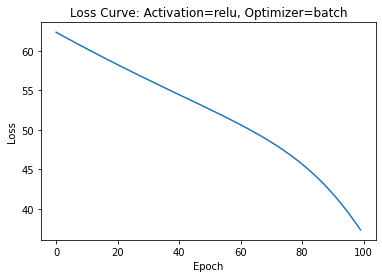

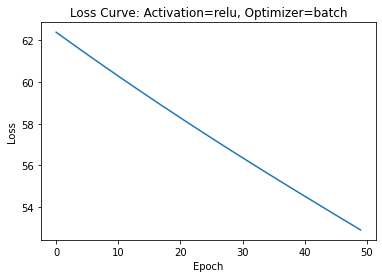

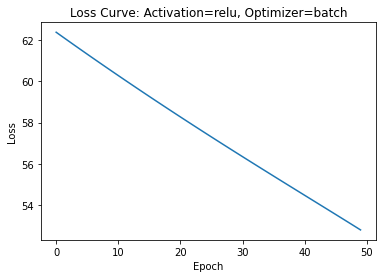

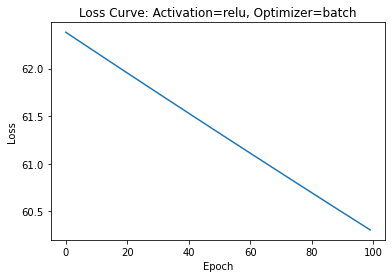

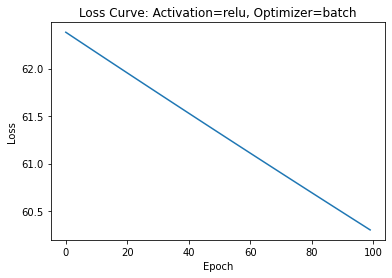

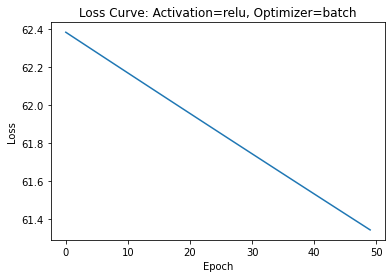

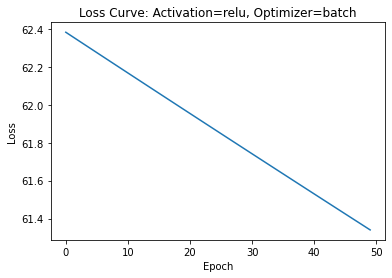

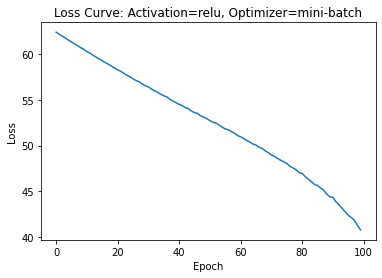

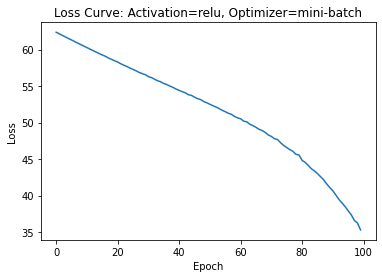

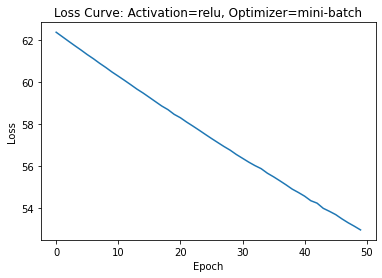

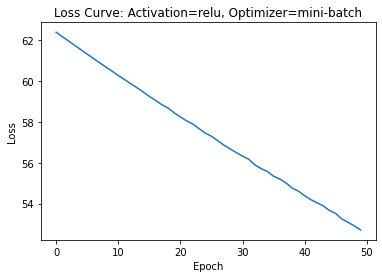

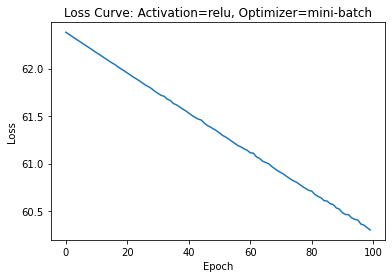

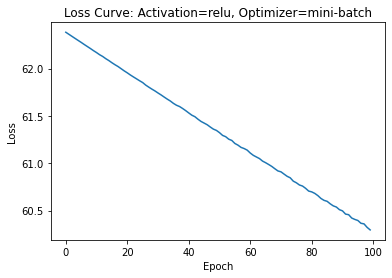

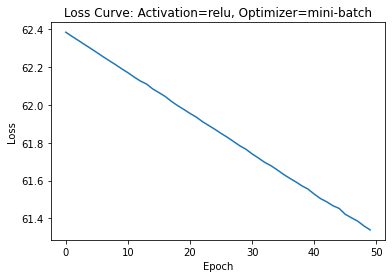

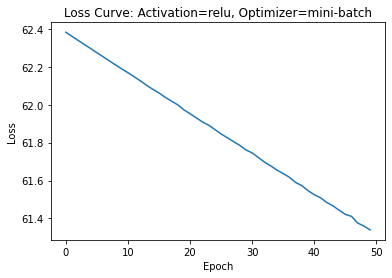

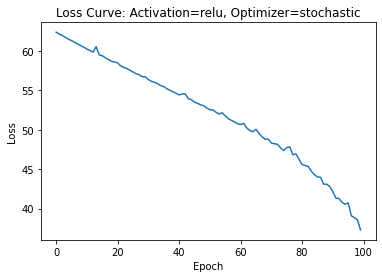

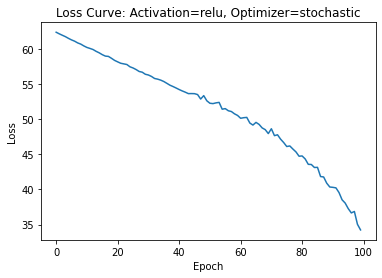

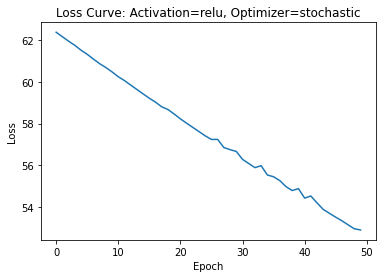

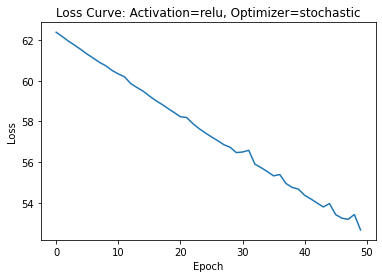

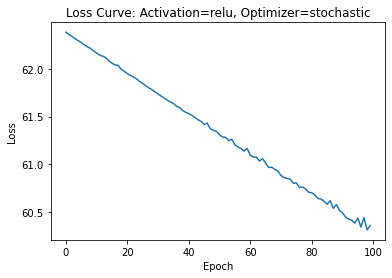

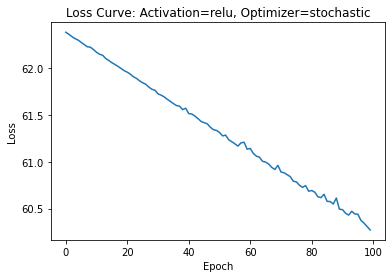

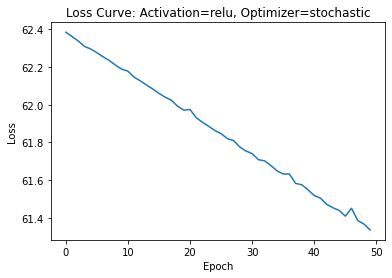

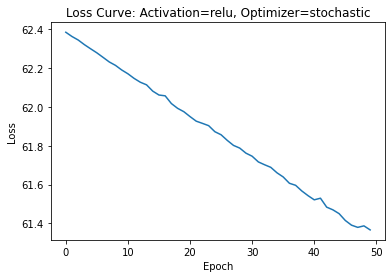

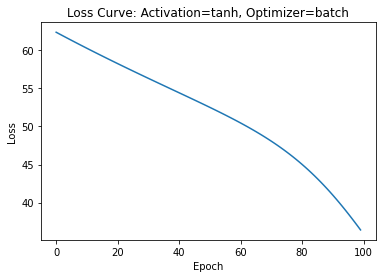

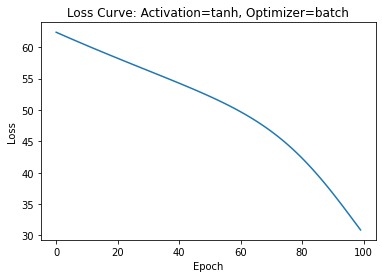

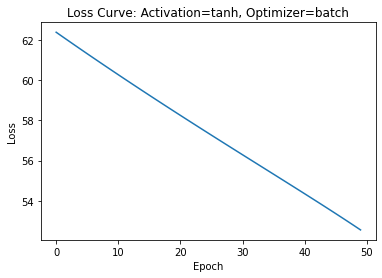

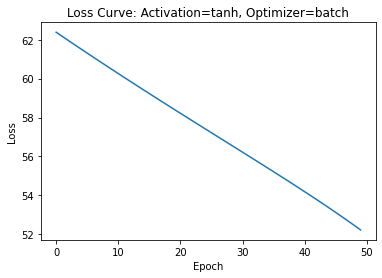

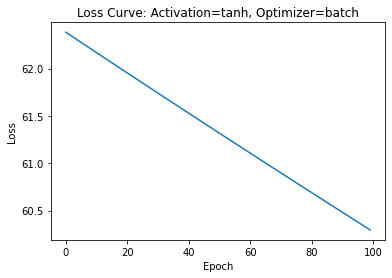

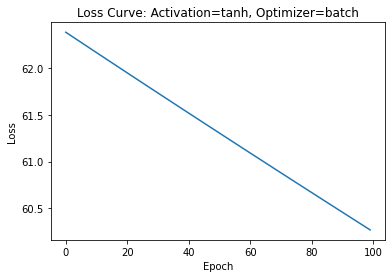

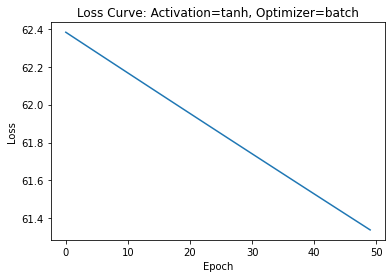

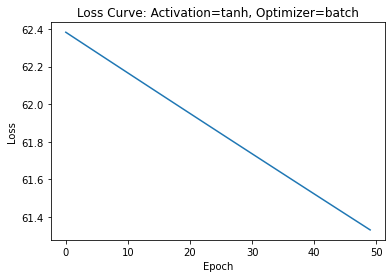

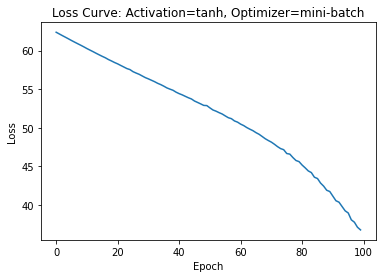

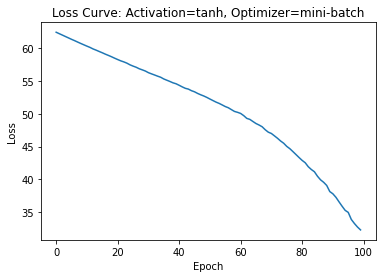

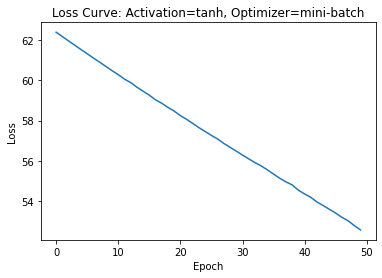

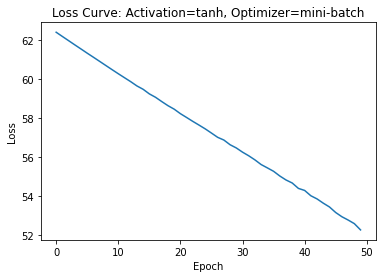

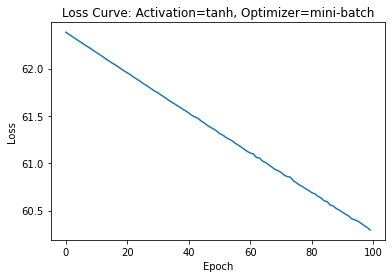

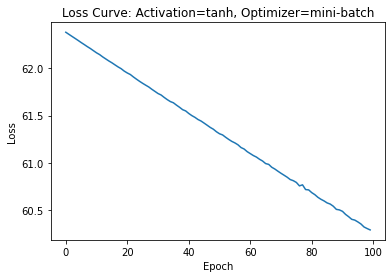

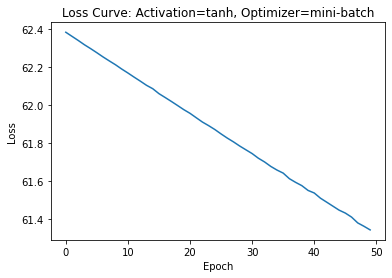

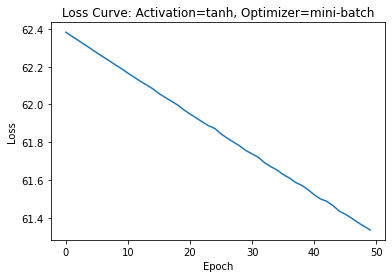

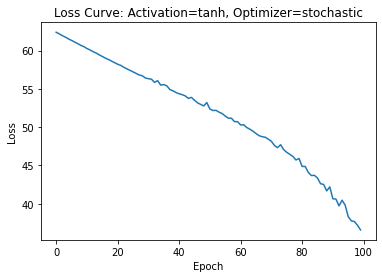

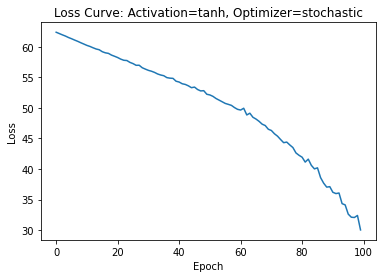

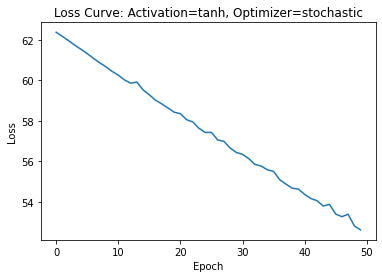

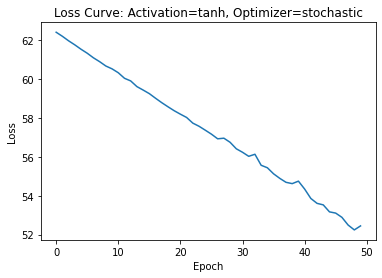

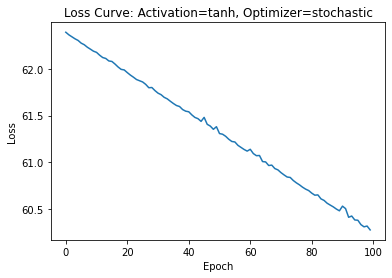

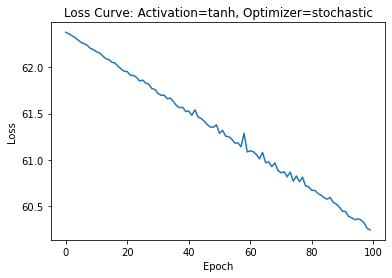

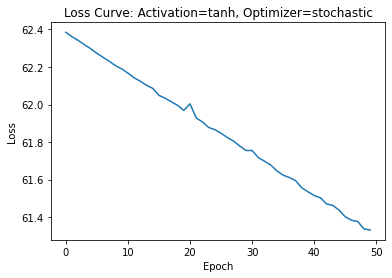

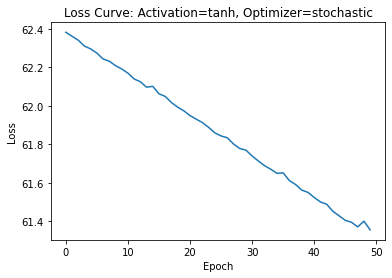

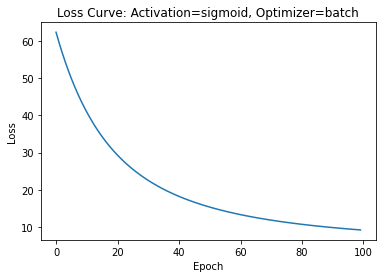

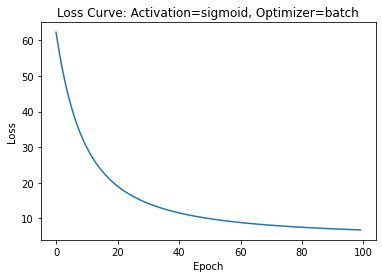

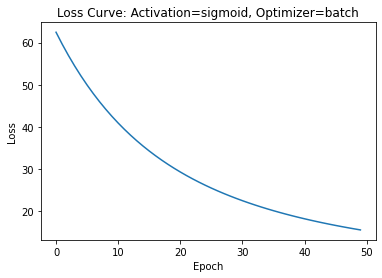

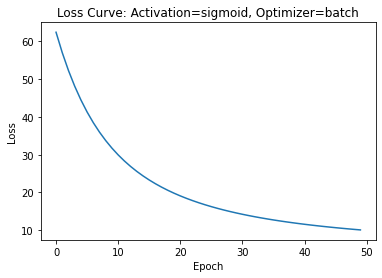

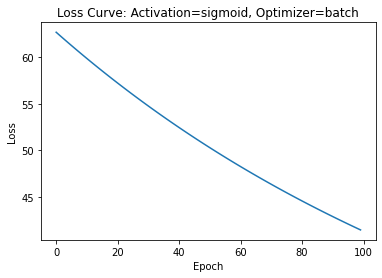

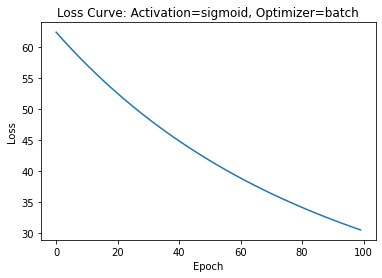

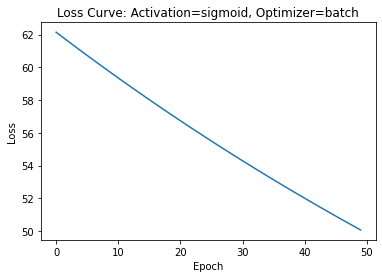

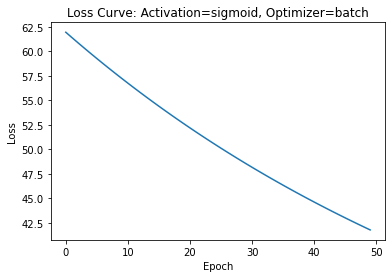

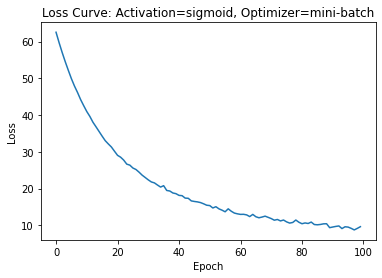

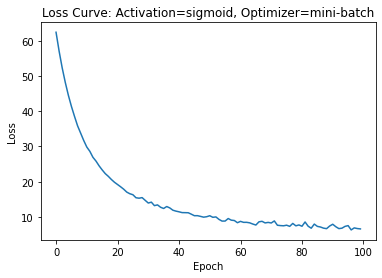

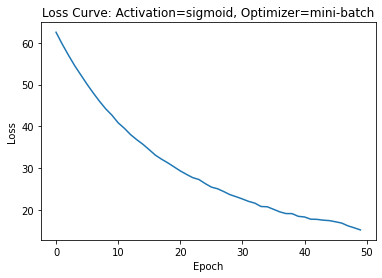

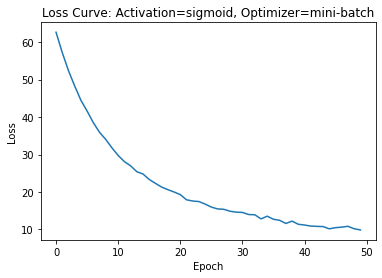

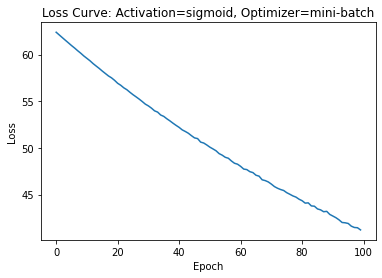

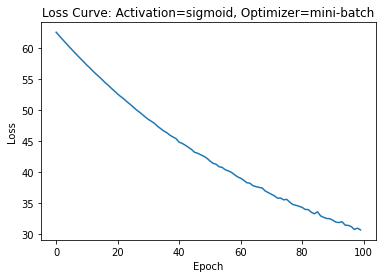

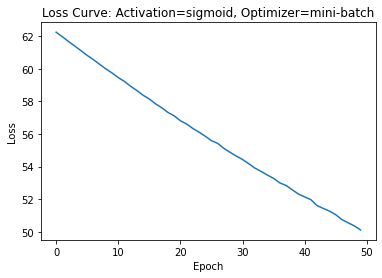

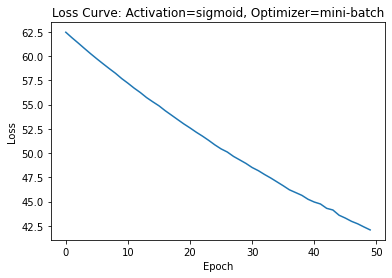

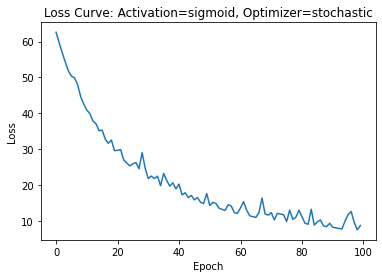

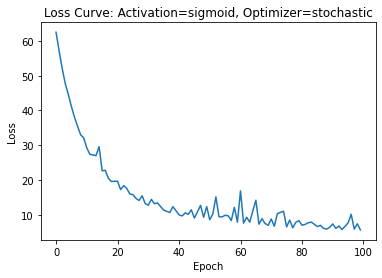

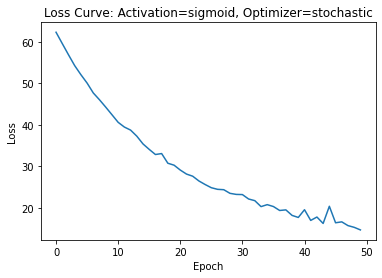

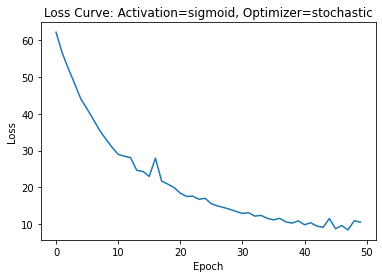

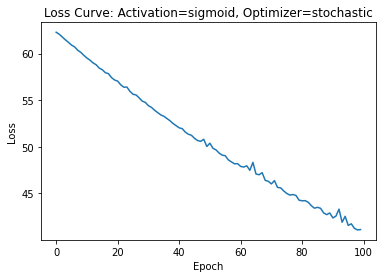

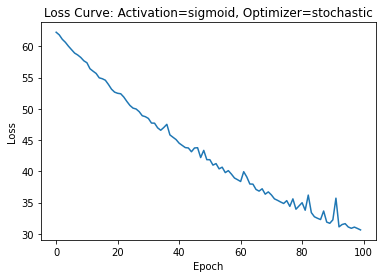

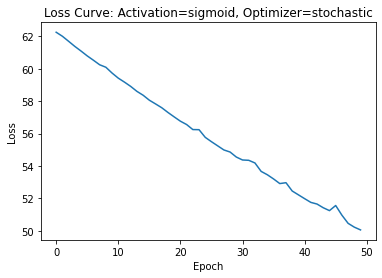

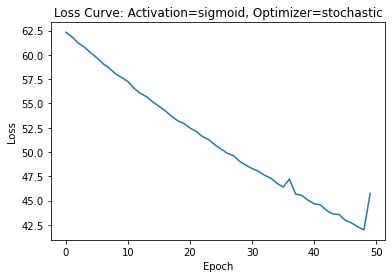

   Activation   Optimizer  Learning Rate  Epochs  Batch Size  Accuracy  \
0        relu       batch          0.010     100         NaN  0.382883   
45       tanh  stochastic          0.001     100         1.0  0.382883   
51    sigmoid       batch          0.010      50         NaN  0.382883   
50    sigmoid       batch          0.010      50         NaN  0.382883   
49    sigmoid       batch          0.010     100         NaN  0.382883   
48    sigmoid       batch          0.010     100         NaN  0.382883   
47       tanh  stochastic          0.001      50         1.0  0.382883   
46       tanh  stochastic          0.001      50         1.0  0.382883   
44       tanh  stochastic          0.001     100         1.0  0.382883   
53    sigmoid       batch          0.001     100         NaN  0.382883   
43       tanh  stochastic          0.010      50         1.0  0.382883   
42       tanh  stochastic          0.010      50         1.0  0.382883   
41       tanh  stochastic          0.0

In [26]:
import pandas as pd
import numpy as np
import re
from collections import Counter, defaultdict
np.set_printoptions(threshold=np.inf)
# --- Data Preprocessing Functions ---

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

def build_vocabulary(docs, max_features=5000):
    counter = Counter()
    for doc in docs:
        tokens = preprocess_text(doc).split()
        counter.update(tokens)
    vocab = [word for word, _ in counter.most_common(max_features)]
    word_to_index = {word: i for i, word in enumerate(vocab)}
    return word_to_index

def compute_tfidf(docs, word_to_index):
    N = len(docs)
    tfidf_matrix = np.zeros((N, len(word_to_index)))
    df = defaultdict(int)
    
    doc_tokens = []
    for i, doc in enumerate(docs):
        tokens = preprocess_text(doc).split()
        doc_tokens.append(tokens)
        token_counts = Counter(tokens)
        for word in token_counts:
            if word in word_to_index:
                df[word] += 1
        for word, count in token_counts.items():
            if word in word_to_index:
                tf = count / len(tokens)
                tfidf_matrix[i, word_to_index[word]] = tf

    for word, index in word_to_index.items():
        idf = np.log((N + 1) / (df[word] + 1)) + 1  # smoothing
        tfidf_matrix[:, index] *= idf
    return tfidf_matrix

def multi_label_binarizer(label_list):
    unique_labels = set()
    split_labels = []
    for labels in label_list:
        split_labels.append(labels)
        unique_labels.update(labels)
    unique_labels = sorted(unique_labels)
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    
    binary_matrix = np.zeros((len(label_list), len(unique_labels)))
    for i, tokens in enumerate(split_labels):
        for token in tokens:
            binary_matrix[i, label_to_index[token]] = 1
    return binary_matrix, label_to_index

def train_val_split(X, y, val_ratio=0.2, shuffle=True):
    m = X.shape[0]
    indices = np.arange(m)
    if shuffle:
        np.random.shuffle(indices)
    split = int(m * (1 - val_ratio))
    train_indices = indices[:split]
    val_indices = indices[split:]
    return X[train_indices], X[val_indices], y[train_indices], y[val_indices]

# --- Load and Preprocess the Data ---

# Load CSV data (assuming 'news_articles.csv' contains 'document' and 'category' columns)
data = pd.read_csv("news-article/train.csv")
data.dropna(subset=["document", "category"], inplace=True)
data['labels'] = data['category'].apply(lambda x: [label.strip() for label in x.split(',') if label.strip()])

# Prepare text documents and compute TF-IDF features
documents = data['document'].tolist()
vocab = build_vocabulary(documents)                  # Build vocabulary limited to ~5000 words
X_features = compute_tfidf(documents, vocab)           # Compute TF-IDF matrix

# Transform labels into binary matrix
y_binary, label_mapping = multi_label_binarizer(data['labels'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_val_split(X_features, y_binary)
# print(y_val)


class MLP:
    def __init__(self, layers, learning_rate=0.01, activation='relu'):
        self.layers = layers
        self.learning_rate = learning_rate
        self.activation_name = activation
        self.weights = []
        self.biases = []
        self._init_weights()
        
    def _init_weights(self):
        for i in range(len(self.layers) - 1):
            w = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            b = np.zeros((1, self.layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def activation(self, z):
        if self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-z))
        elif self.activation_name == 'tanh':
            return np.tanh(z)
        elif self.activation_name == 'relu':
            return np.maximum(0, z)
        else:
            raise ValueError("Unknown activation function")
    
    def activation_derivative(self, z):
        if self.activation_name == 'sigmoid':
            a = 1 / (1 + np.exp(-z))
            return a * (1 - a)
        elif self.activation_name == 'tanh':
            return 1 - np.tanh(z)**2
        elif self.activation_name == 'relu':
            return (z > 0).astype(float)
        else:
            raise ValueError("Unknown activation function")
    
    def forward(self, X):
        self.Z = []  # store linear outputs
        self.A = [X] # store activations
        for i in range(len(self.weights)):
            z = np.dot(self.A[-1], self.weights[i]) + self.biases[i]
            self.Z.append(z)
            if i == len(self.weights) - 1:
                a = 1 / (1 + np.exp(-z))  # using sigmoid for output layer
            else:
                a = self.activation(z)
            self.A.append(a)
        return self.A[-1]
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        loss = -np.sum(y_true * np.log(y_pred + 1e-8) + (1 - y_true) * np.log(1 - y_pred + 1e-8)) / m
        return loss
    
    def backward(self, y_true):
        m = y_true.shape[0]
        self.dW = [None] * len(self.weights)
        self.db = [None] * len(self.biases)
        dA = self.A[-1] - y_true
        
        for i in reversed(range(len(self.weights))):
            if i == len(self.weights) - 1:
                dZ = dA
            else:
                dZ = dA * self.activation_derivative(self.Z[i])
            self.dW[i] = np.dot(self.A[i].T, dZ) / m
            self.db[i] = np.sum(dZ, axis=0, keepdims=True) / m
            dA = np.dot(dZ, self.weights[i].T)
    
    def update_parameters(self):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * self.dW[i]
            self.biases[i] -= self.learning_rate * self.db[i]
    
    def train(self, X, y, epochs=100, batch_size=None, verbose=True):
        m = X.shape[0]
        losses = []
        for epoch in range(epochs):
            if batch_size is None or batch_size >= m:
                X_batch, y_batch = X, y
            else:
                indices = np.random.permutation(m)
                X_batch = X[indices][:batch_size]
                y_batch = y[indices][:batch_size]
            
            y_pred = self.forward(X_batch)
            loss = self.compute_loss(y_batch, y_pred)
            losses.append(loss)
            self.backward(y_batch)
            self.update_parameters()
            
            if verbose and epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss}")
        return losses

def accuracy_score(y_true, y_pred, threshold=0.42):
    y_pred_bin = (y_pred >= threshold).astype(float)
    # print(y_pred_bin)
    # print(y_true)
    correct = np.all(y_true == y_pred_bin, axis=1).sum()
    return correct / y_true.shape[0]

def hamming_loss_metric(y_true, y_pred, threshold=0.42):
    y_pred_bin = (y_pred >= threshold).astype(float)
    return np.mean(np.not_equal(y_true, y_pred_bin))

def get_top1_predictions(y_pred):
    y_pred_bin = np.zeros_like(y_pred)
    # Get the index of the maximum score for each sample
    top1_indices = np.argmax(y_pred, axis=1)
    # Set the corresponding indices to 1 for each sample
    y_pred_bin[np.arange(y_pred.shape[0]), top1_indices] = 1.0
    return y_pred_bin

# Example usage within your accuracy and hamming loss functions:
def accuracy_score_top1(y_true, y_pred):
    y_pred_bin = get_top1_predictions(y_pred)
    correct = np.all(y_true == y_pred_bin, axis=1).sum()
    return correct / y_true.shape[0]

def hamming_loss_metric_top1(y_true, y_pred):
    y_pred_bin = get_top1_predictions(y_pred)
    return np.mean(np.not_equal(y_true, y_pred_bin))


import matplotlib.pyplot as plt

# List of hyperparameter configurations to test
# configurations = [
#     {'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch''hidden_layer_sizes': 100},
#     {'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': None, 'optimizer': 'batch'},
#     {'activation': 'relu', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 1, 'optimizer': 'stochastic'},
#     {'activation': 'tanh', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'},
#     {'activation': 'sigmoid', 'learning_rate': 0.01, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'},
#     {'activation': 'relu', 'learning_rate': 0.001, 'epochs': 100, 'batch_size': 32, 'optimizer': 'mini-batch'},
# ]

configurations = []
activations = ['relu', 'tanh', 'sigmoid']
optimizers = ['batch', 'mini-batch', 'stochastic']
learning_rates = [0.01, 0.001]
epochs_list = [100, 50]
hidden_layer_sizes = [50, 100]

for activation in activations:
    for optimizer in optimizers:
        # Set batch_size based on optimizer type
        if optimizer == 'batch':
            batch_size = None
        elif optimizer == 'mini-batch':
            batch_size = 32
        elif optimizer == 'stochastic':
            batch_size = 1
        
        for lr in learning_rates:
            for epoch in epochs_list:
                for hidden_size in hidden_layer_sizes:
                    config = {
                        'activation': activation,
                        'optimizer': optimizer,
                        'learning_rate': lr,
                        'epochs': epoch,
                        'hidden_layer_sizes': hidden_size,
                        'batch_size': batch_size
                    }
                    configurations.append(config)

# Display the total number of configurations and print a few examples
# print(f"Total configurations: {len(configurations)}")
# for config in configurations[:5]:
#     print(config)


results = []

for config in configurations:
    # print("Training configuration:", config)
    
    # Initialize a new MLP for each configuration
    mlp_model = MLP(
        layers=[X_train.shape[1], config['hidden_layer_sizes'], y_train.shape[1]],
        learning_rate=config['learning_rate'],
        activation=config['activation']
    )
    
    # Train the model using the training set and record the loss curve
    losses = mlp_model.train(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], verbose=False)
    # print(losses)
    
    # Evaluate the model on the validation set
    y_val_pred = mlp_model.forward(X_val)
    # print(y_val_pred)
    # acc = accuracy_score(y_val, y_val_pred)
    # h_loss = hamming_loss_metric(y_val, y_val_pred)
    acc = accuracy_score_top1(y_val, y_val_pred)
    h_loss = hamming_loss_metric_top1(y_val, y_val_pred)
    
    # Store configuration and evaluation results
    results.append({
        'config': config,
        'losses': losses,
        'accuracy': acc,
        'hamming_loss': h_loss
    })
    
    print(f"Validation Accuracy: {acc:.4f}, Hamming Loss: {h_loss:.4f}\n")

for result in results:
    config = result['config']
    plt.figure()
    plt.plot(result['losses'])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve: Activation={config['activation']}, Optimizer={config['optimizer']}")
    plt.show()

import pandas as pd

summary_table = pd.DataFrame({
    'Activation': [r['config']['activation'] for r in results],
    'Optimizer': [r['config']['optimizer'] for r in results],
    'Learning Rate': [r['config']['learning_rate'] for r in results],
    'Epochs': [r['config']['epochs'] for r in results],
    'Batch Size': [r['config']['batch_size'] for r in results],
    'Accuracy': [r['accuracy'] for r in results],
    'Hamming Loss': [r['hamming_loss'] for r in results],
})

# Sort the table by accuracy (highest first)
summary_table = summary_table.sort_values(by='Accuracy', ascending=False)
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
print(summary_table)

    